In [ ]:
import os
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
config = AttrDict()

In [ ]:
config.data_path = '/content/drive/MyDrive/Implement/StyleTransfer'

config.n_epoch = 1000
config.learning_rate = 1e-2
config.augmentation_c = transforms.Compose([
                        # transforms.Resize((600, 1200)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                      ])
config.augmentation_s = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                      ])
config.denormalize = lambda x: x * torch.tensor([[[0.229]], [[0.224]], [[0.225]]])+torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
content = Image.open(config.data_path + '/content_2.jpg')
style = Image.open(config.data_path + '/style_6.jpg')

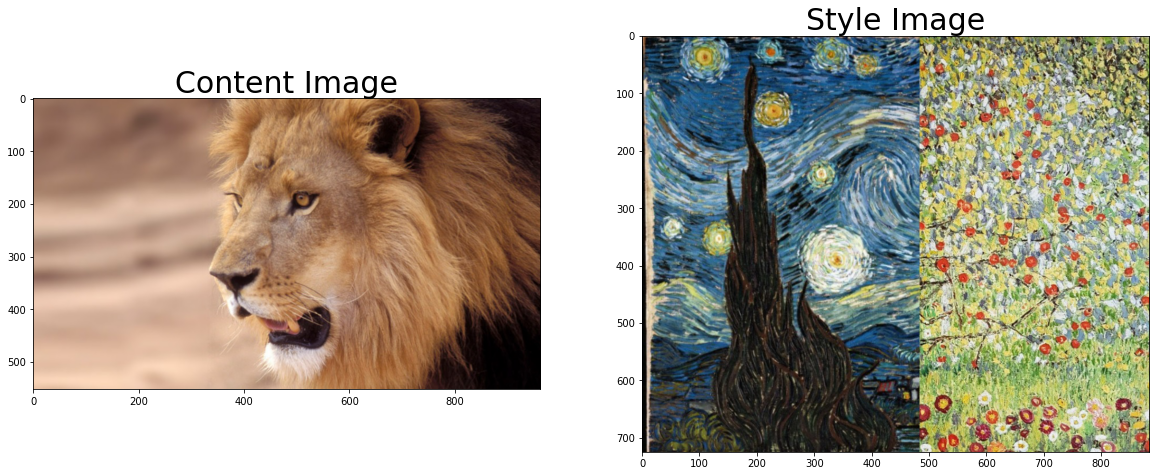

In [ ]:
fig = plt.figure(figsize = (20, 40))
plt.subplot(121)
plt.title('Content Image', fontsize = 30)
plt.imshow(content)

plt.subplot(122)
plt.title('Style Image', fontsize = 30)
plt.imshow(style)

In [ ]:
content.size

(963, 552)

In [ ]:
vgg = torchvision.models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
A = [1, 2, 3]
B = [0, 0, 0]
for n, i in enumerate(vgg.features):
    if n in A:
        print(i)

ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


In [ ]:
class feature_extractor(nn.Module):
    def __init__(self):
        super(feature_extractor, self).__init__()
        self.model = models.vgg19(pretrained = True)
        # conv1_1, 2_1, 3_1, 4_1, 5_1
        self.num_layers = [0, 5, 10, 19, 28]

    def forward(self, x):
        fm_list = []
        for n, layer in enumerate(self.model.features):
            x = layer(x)
            if n in self.num_layers:
                fm_list.append(x)
        return fm_list

In [ ]:
torch.randn((2, 3, 4))

tensor([[[ 1.0054e+00,  2.3117e+00, -5.7520e-01,  3.9602e-01],
         [-4.6029e-01, -1.8322e-01,  1.0496e+00, -2.8143e+00],
         [ 1.5329e+00,  2.8350e+00,  7.1855e-03, -6.1020e-01]],

        [[-4.5461e-01, -4.9056e-01, -3.7670e-04, -1.5736e-04],
         [ 8.4607e-01, -1.1462e+00,  1.1772e+00,  1.9860e-01],
         [-8.7089e-01,  1.4012e-02, -1.0478e+00,  4.3893e-01]]])

In [ ]:
"""
Gram Matrix 계산
Feature map : C x H x W
output : C x C
"""
f_1 = torch.randn((3, 4, 5))
f_2 = torch.randn((3, 4, 5))

gm = torch.mm(f_1.view(f_1.shape[0], -1), f_2.view(f_2.shape[0], -1).T) / (f_1.shape[1] * f_1.shape[2])
print(gm.shape)
print(gm)

torch.Size([3, 3])
tensor([[-0.0425, -0.1934,  0.2946],
        [-0.2101, -0.4452, -0.2597],
        [-0.3708, -0.1498, -0.4542]])


In [ ]:
content_t = config.augmentation_c(content).unsqueeze(0)
style_t = config.augmentation_s(style).unsqueeze(0)

# output = torch.randn_like(content_t).requires_grad_(True)
output = content_t.clone().requires_grad_(True)

In [ ]:
model = feature_extractor().to(device)
optimizer = torch.optim.Adam([output], lr = config.learning_rate)
criterion = nn.MSELoss()

In [ ]:
model(torch.randn((1, 3, 500, 1200)).to(device))[1].shape

torch.Size([1, 128, 250, 600])

## Style Loss
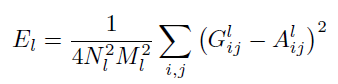

N: channel

M: H*W

In [ ]:
"""
of.shape # (1, 512, 37, 75)
         # (1,  C,  H,   W)
"""

'\nof.shape # (1, 512, 37, 75)\n         # (1,  C,  H,   W)\n'

In [ ]:
for i in tqdm(range(5000)):

    style_loss = 0
    content_loss = 0
    c, s = model(content_t.to(device)), model(style_t.to(device))
    o = model(output.to(device))
    
    for cf, sf, of in zip(c, s, o):
        content_loss += criterion(of, cf)
        s_gm = torch.mm(sf.view(sf.shape[1], -1), sf.view(of.shape[1], -1).T) # G - A
        o_gm = torch.mm(of.view(of.shape[1], -1), of.view(of.shape[1], -1).T) 
        style_loss += criterion(o_gm, s_gm) / 2 / (np.prod(sf.shape))**2
    
    loss = content_loss + style_loss * 1e10
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0 or i == 0:
        print(f"Epoch [{i+1}] Content_loss: {content_loss.item()} Style_loss: {style_loss.item()}")
    if (i+1) % 100 == 0 or i == 0:
        save_img = output.squeeze(0).data.cpu()
        save_img = config.denormalize(save_img).clamp(0., 1.)
        torchvision.utils.save_image(save_img, config.data_path + f"/output_{i+1}.png")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch [1] Content_loss: 0.0 Style_loss: 9.996554581448436e-05
Epoch [100] Content_loss: 28.02872657775879 Style_loss: 6.171577297209296e-06
Epoch [200] Content_loss: 29.429641723632812 Style_loss: 2.5193610326823546e-06
Epoch [300] Content_loss: 30.09421157836914 Style_loss: 1.4136749086901546e-06
Epoch [400] Content_loss: 30.47928237915039 Style_loss: 9.552292112857685e-07
Epoch [500] Content_loss: 30.726308822631836 Style_loss: 7.053606623230735e-07
Epoch [600] Content_loss: 30.907516479492188 Style_loss: 5.413519374997122e-07
Epoch [700] Content_loss: 31.055953979492188 Style_loss: 4.217176012843993e-07
Epoch [800] Content_loss: 31.1829776763916 Style_loss: 3.3054416803679487e-07
Epoch [900] Content_loss: 31.294342041015625 Style_loss: 2.609854448110127e-07
Epoch [1000] Content_loss: 31.393657684326172 Style_loss: 2.0918523091495445e-07
Epoch [1100] Content_loss: 31.481586456298828 Style_loss: 1.7178372502257844e-07
Epoch [1200] Content_loss: 31.561107635498047 Style_loss: 1.4513497

KeyboardInterrupt: ignored